<a href="https://colab.research.google.com/github/arthijayaraman-lab/CREASE-2D/blob/main/CREASE%20Tutorials/ML_model_training%26testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Download the required packages
!pip install xgboost
!pip install scikit-optimize
!pip install scikit-learn==1.2.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 62.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mlxtend 0.23.3 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.


In [11]:
#@title import required libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.utils import shuffle
from skopt.callbacks import VerboseCallback
import matplotlib.pyplot as plt
import skimage.metrics
from sklearn.metrics import mean_squared_error, r2_score
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import gdown
import warnings
warnings.simplefilter('ignore')

In [3]:
#@title Hyperparameter fine-tuning to find optimal hyper parameters for XGBoost Model (Do not run this step if you are using free subscription of colab)

#Download dataset we shared from google drive
training_data_id = '1vp7JxcX_RxyXbl3at5HFqbR3oJtW5Kjg'
training_data = gdown.download(id=training_data_id, output='training_data', quiet=False)

#access the dataset
df = pd.read_csv(training_data)
df_shuffled = shuffle(df, random_state=189)
X = df_shuffled.drop(columns=['I_q', 'Sample ID'])
y = df_shuffled['I_q']

#define the parameter space to get the optimized values using Bayesian optimization
param_space = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(2, 15),
    'learning_rate': Real(0.1, 0.3, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bylevel': Real(0.5, 1.0),
    'gamma': Real(0.0, 1.0),
    'min_child_weight': Integer(1, 10),
    'reg_lambda': Real(0.1, 1.0, prior='log-uniform'),
    'reg_alpha': Real(0.1, 1.0, prior='log-uniform')
}

xgb_reg = xgb.XGBRegressor(tree_method='hist', importance_type='cover',device='cuda', random_state=51)

#We use Skopt library to tume the parameter space
opt = BayesSearchCV(
    xgb_reg,param_space,n_iter=30,cv=3,n_jobs=-1,
    random_state=42,verbose=50, refit=False,
    optimizer_kwargs={'base_estimator': 'GP'}
)

#Train the model
opt.fit(X, y,callback=VerboseCallback(30))
best_params = opt.best_params_
best_score = opt.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

#Train the XGBoost model with tuned hyperparameters on CPUs
final_xgb = xgb.XGBRegressor(**best_params, tree_method='hist', importance_type='cover', random_state=51)
final_xgb.fit(X,y)
cover_importance = final_xgb.feature_importances_
print("Feature importance weights:", cover_importance)
final_xgb.save_model('xgbmodel_2400_126.json')

Downloading...
From (original): https://drive.google.com/uc?id=1vp7JxcX_RxyXbl3at5HFqbR3oJtW5Kjg
From (redirected): https://drive.google.com/uc?id=1vp7JxcX_RxyXbl3at5HFqbR3oJtW5Kjg&confirm=t&uuid=79b9d958-5d56-4615-aa2f-8ce27ee36ba9
To: /content/training_data
100%|██████████| 1.12G/1.12G [00:05<00:00, 194MB/s]


Iteration No: 1 started. Searching for the next optimal point.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 47.5789
Function value obtained: -0.9958
Current minimum: -0.9958
Iteration No: 2 started. Searching for the next optimal point.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 35.5780
Function value obtained: -0.9960
Current minimum: -0.9960
Iteration No: 3 started. Searching for the next optimal point.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 25.7970
Function value obtained: -0.9944
Current minimum: -0.9960
Iteration No: 4 started. Searching for the next optimal point.
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken

In [116]:
#@title Load trained ML model and test on test dataset
model_file_id = '1Q9ztgJ5mXpqixjasceUYC2_zHBIwm73O'
test_data_id = '1Wp9R3b1GTiGRMOuwlurakzmdhV-ba_W-'
model = gdown.download(id=model_file_id, output='model', quiet=False)
loaded_model = xgb.Booster(model_file=model)
test_data = gdown.download(id=test_data_id, output='test_dataset', quiet=False)
test_data = pd.read_csv(test_data)

def plot_comparison_images(original, predicted, sample_id):
    """
    Plots side-by-side comparison of original and predicted matrices.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    titles = ['Original', 'Predicted']
    matrices = [original, predicted]

    for ax, matrix, title in zip(axes, matrices, titles):
        im = ax.imshow(matrix, cmap='inferno')
        ax.set_title(title, fontsize=16)
        ax.set_xlabel("Azimuthal angle (θ)", fontsize=14)
        ax.set_ylabel("log(q)", fontsize=14)
        ax.grid(False)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    plt.tight_layout()
    # Uncomment to save the figure
    # fig.savefig(f'data/test_sample_{sample_id}_comparison.png', format='png')
    plt.show()

def prepare_polar_data(matrix):
    flipped = matrix[:, ::-1]
    full = np.hstack((flipped, flipped))
    return full

def plot_polar(original, predicted):
    """
    Plots the original and predicted data in polar coordinates.
    """
    def create_polar_plot(ax, data, title):
        theta_deg_full = np.linspace(360, 0, data.shape[1])
        theta_full = np.radians(theta_deg_full)
        q = np.arange(data.shape[0])
        T, Q = np.meshgrid(theta_full, q)
        im = ax.pcolormesh(T, Q, data, cmap='inferno')
        ax.set_theta_zero_location("E")
        ax.set_theta_direction(1)
        ax.grid(False)
        ax.set_rticks([])
        ax.set_title(title, fontsize=16)
        return im

    fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection='polar'), figsize=(14, 6))
    titles = ['Original Polar', 'Predicted Polar']
    datasets = [original, predicted]

    for ax, data, title in zip(axes, datasets, titles):
        im = create_polar_plot(ax, data, title)
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='I(q)')

    plt.tight_layout()
    plt.show()

Downloading...
From: https://drive.google.com/uc?id=1Q9ztgJ5mXpqixjasceUYC2_zHBIwm73O
To: /content/model
100%|██████████| 55.9M/55.9M [00:00<00:00, 203MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Wp9R3b1GTiGRMOuwlurakzmdhV-ba_W-
To: /content/test_dataset
100%|██████████| 4.50M/4.50M [00:00<00:00, 210MB/s]


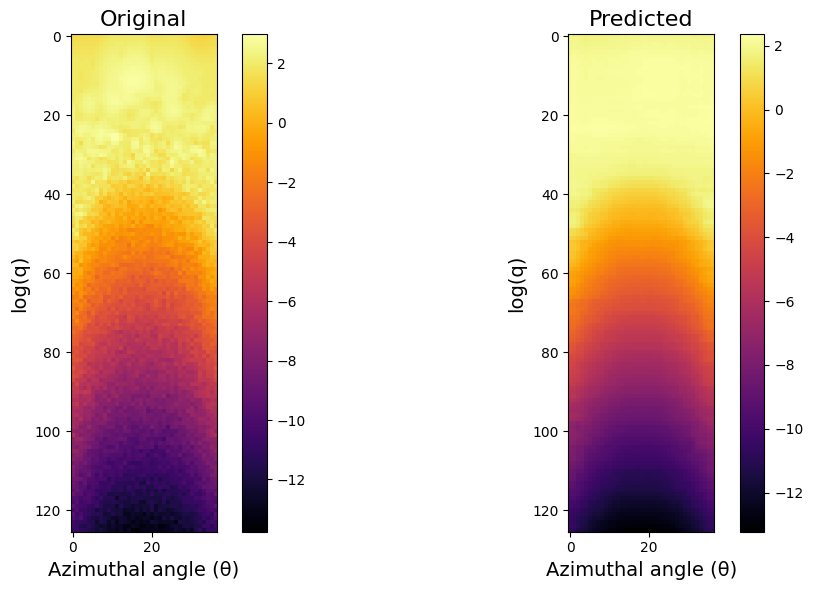

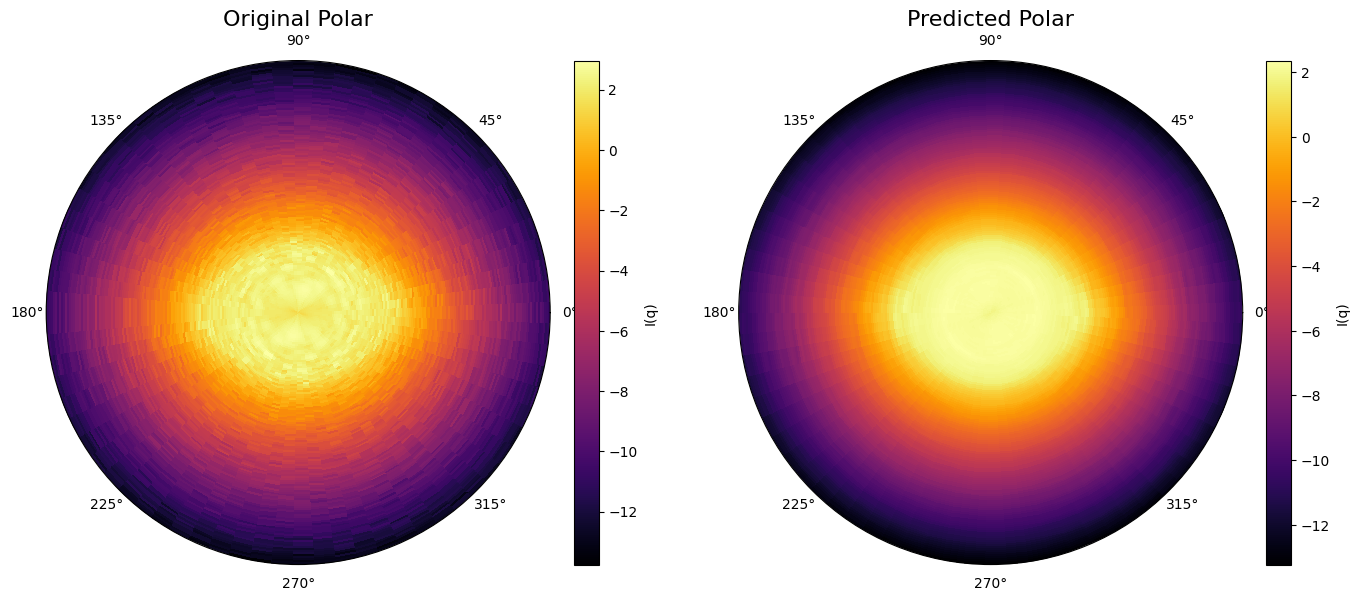

Sample ID: 10
Mean Squared Error (MSE): 0.1023
R-squared (R²): 0.9957
Peak Signal-to-Noise Ratio (PSNR): 34.3652
Structural Similarity Index (SSIM): 0.8541


In [126]:
#@title We provided 10 test samples with id's 1 to 10. Change IDs and see the outputs

sample_id = 10
filtered = test_data[test_data['Sample ID'] == sample_id]
X_sample_test = filtered.drop(columns=['I_q', 'Sample ID'])
y_sample_test = filtered['I_q']

# Predict using the loaded model
X_sample_test_dm = xgb.DMatrix(X_sample_test)
predicted = loaded_model.predict(X_sample_test_dm)

# Calculate metrics
r2 = r2_score(y_sample_test, predicted)
mse = mean_squared_error(y_sample_test, predicted)
data_range = np.max(y_sample_test) - np.min(y_sample_test)
predicted_matrix = predicted.reshape(126, 37)
original_matrix = y_sample_test.to_numpy().reshape(126, 37)
psnr = skimage.metrics.peak_signal_noise_ratio(original_matrix, predicted_matrix, data_range=data_range)
ssim = skimage.metrics.structural_similarity(original_matrix, predicted_matrix, data_range=data_range)

# Plotting
plot_comparison_images(original_matrix, predicted_matrix, sample_id)

original_polar = prepare_polar_data(original_matrix)
predicted_polar = prepare_polar_data(predicted_matrix)

plot_polar(original_polar, predicted_polar)

# Print metrics
print(f"Sample ID: {sample_id}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.4f}")
print(f"Structural Similarity Index (SSIM): {ssim:.4f}")
